In [1]:
import scipy.io
import pickle
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, add, LSTM, Dense, Dropout,GRU, Bidirectional, MaxPooling1D
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA

from scipy.io import loadmat

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
directory = 'Data'

all_data = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.mat'):
        filepath = os.path.join(directory, filename)
        
        # Load the .mat file and add its contents to the dictionary
        mat_data = loadmat(filepath)
        
        # Use filename (without extension) as key for the data
        key = os.path.splitext(filename)[0]
        row_means = np.mean(mat_data['acceleration'],1)
        rows_2_keep = row_means != 0
        all_data[key] = mat_data['acceleration'][rows_2_keep]
        
keys_to_stack = [f'spaceframe{i}' for i in range(1,11)]
input_data = np.stack([all_data[key] for key in keys_to_stack], axis=0)

# Create the corresponding labels
output_labels = np.linspace(0,10,11)  # Using 0 and 1 as class labels for binary cross-entropy
label = output_labels

input_data = input_data[:,:,:15000]
input_data.shape, output_labels.shape

((10, 24, 10000), (11,))

(24, 10000)


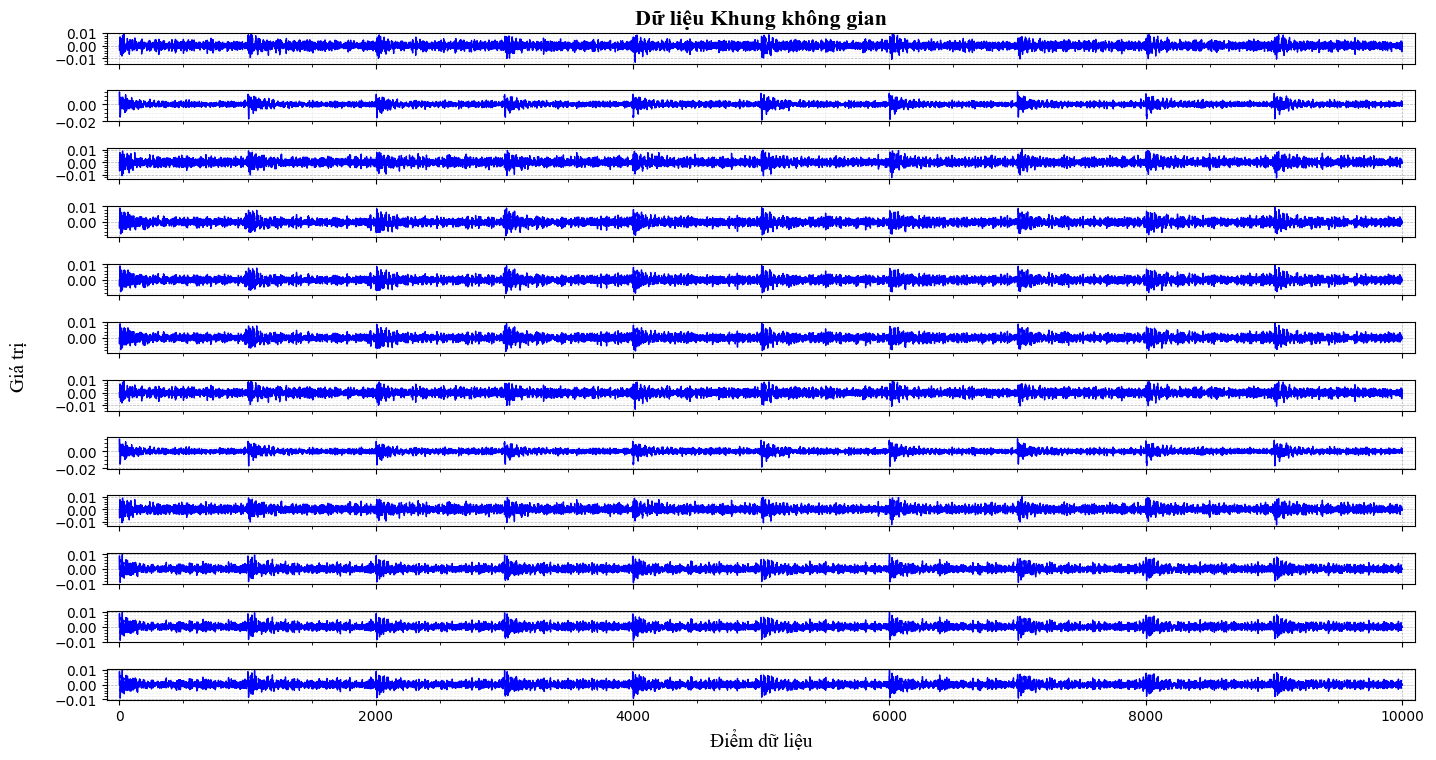

In [3]:
# Select the data at index (1, 1, :) which has a shape of (8000,)
Data = input_data[1,:, :]
print(Data.shape)
# Create the plot
fig, axes = plt.subplots(12, 1, figsize=(15, 8), sharex=True)

title_font = {'family': 'Times New Roman', 'size': 16, 'weight': 'bold'}
label_font = {'family': 'Times New Roman', 'size': 14}
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['font.family'] = 'sans-serif'

# Plot the data for each sub-array
for i, ax in enumerate(axes):
    ax.plot(Data[i, :], linewidth=1, color = 'b')
    # ax.set_title(f'Z24 Signal Data at Index (1, {i}, :)', fontsize=12)
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.minorticks_on()
    ax.grid(True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    ax.set_xlim(-100, Data.shape[1]+100)
# Set common labels using axes
axes[-1].set_xlabel('Điểm dữ liệu', fontsize=14, fontdict=label_font)
axes[0].set_title('Dữ liệu Khung không gian', fontsize=16, fontdict=title_font)

# Create a "super" axis for the common Y-label and make it invisible
super_ax = fig.add_subplot(111, frame_on=False)
plt.tick_params(labelcolor="none", bottom=False, left=False)
super_ax.set_ylabel("Giá trị", fontsize=14, labelpad=15, fontdict=label_font)

# Move the super axis ylabel to avoid overlap with subplots
super_ax.yaxis.set_label_coords(-0.06,0.5)

# Adjust the layout so that plots do not overlap
plt.tight_layout()
plt.show()



In [4]:
def check_for_different_shapes(arrays):
    """
    Kiểm tra xem các mảng trong danh sách có kích thước không đồng nhất không.

    Parameters:
        arrays (list): Danh sách các mảng NumPy.

    Returns:
        list: Danh sách các mảng không đồng nhất.
    """
    inhomogeneous_arrays = []
    expected_shape = None
    for array in arrays:
        if expected_shape is None:
            expected_shape = array.shape
        elif array.shape != expected_shape:
            inhomogeneous_arrays.append(array)
    return inhomogeneous_arrays

def augment_time_series_data(input_data, labels, num_augmentations=5):
    """
    Augment time series data.

    :param input_data: Original time series data array.
    :param labels: Corresponding labels for the data.
    :param num_augmentations: Number of augmented samples to generate per original sample.

    :return: Augmented data array and corresponding labels.
    """
    augmented_data = []
    augmented_labels = []

    num_samples, num_channels, sequence_length = input_data.shape

    for i in range(num_samples):
        for _ in range(num_augmentations):
            # Choose a random augmentation technique
            augmentation_type = random.choices(['noise', 'reverse', 'crop_pad', 'time_warp', 'random_shift'],
                                               weights=[0.2, 0.2, 0.2, 0.2, 0.2])[0]

            if augmentation_type == 'noise':
                # Add random noise
                noise = np.random.normal(0, 0.00005, input_data[i].shape)
                augmented_sample = input_data[i] + noise

            elif augmentation_type == 'reverse':
                # Reverse the sequence
                augmented_sample = np.flip(input_data[i], axis=-1)

            elif augmentation_type == 'crop_pad':
                # Crop and pad the sequence
                crop_size = random.randint(1, sequence_length // 100)
                padded_sample = np.pad(input_data[i], ((0, 0), (crop_size, 0)), mode='constant', constant_values=0)
                augmented_sample = padded_sample[:, :-crop_size]

            elif augmentation_type == 'time_warp':
                # Time warping
                start_idx = random.randint(0, sequence_length // 2)
                end_idx = random.randint(start_idx, sequence_length)
                warped_segment = np.mean(input_data[i][:, start_idx:end_idx], axis=1, keepdims=True)
                augmented_sample = np.concatenate((warped_segment, input_data[i][:, end_idx:]), axis=1)

            elif augmentation_type == 'random_shift':
                # Random shifting
                shift_amount = random.randint(-(sequence_length // 10), sequence_length // 10)
                augmented_sample = np.roll(input_data[i], shift_amount, axis=-1)

            if augmented_sample.shape == (num_channels, sequence_length):
                augmented_data.append(augmented_sample)
                augmented_labels.append(labels[i])
            else:
                print("Invalid shape:", augmented_sample.shape)

    # Convert to numpy arrays
    # Sử dụng hàm
    inhomogeneous_arrays = check_for_different_shapes(augmented_data)
    if inhomogeneous_arrays:
        print("Các mảng không đồng nhất:")
        for array in inhomogeneous_arrays:
            print(array.shape)
    else:
        print("Tất cả các mảng có kích thước giống nhau.")

    return np.array(augmented_data), np.array(augmented_labels)

# Sử dụng hàm
augmented_data, augmented_labels = augment_time_series_data(input_data, output_labels, num_augmentations=30)
print(augmented_data.shape, augmented_labels.shape)



Invalid shape: (24, 3751)
Invalid shape: (24, 184)
Invalid shape: (24, 8025)
Invalid shape: (24, 5268)
Invalid shape: (24, 6131)
Invalid shape: (24, 2440)
Invalid shape: (24, 2627)
Invalid shape: (24, 2592)
Invalid shape: (24, 4598)
Invalid shape: (24, 5861)
Invalid shape: (24, 3541)
Invalid shape: (24, 5355)
Invalid shape: (24, 842)
Invalid shape: (24, 4872)
Invalid shape: (24, 1300)
Invalid shape: (24, 4873)
Invalid shape: (24, 5787)
Invalid shape: (24, 388)
Invalid shape: (24, 471)
Invalid shape: (24, 2678)
Invalid shape: (24, 810)
Invalid shape: (24, 2309)
Invalid shape: (24, 3181)
Invalid shape: (24, 2285)
Invalid shape: (24, 2544)
Invalid shape: (24, 2054)
Invalid shape: (24, 7945)
Invalid shape: (24, 4238)
Invalid shape: (24, 1478)
Invalid shape: (24, 1172)
Invalid shape: (24, 1925)
Invalid shape: (24, 7024)
Invalid shape: (24, 270)
Invalid shape: (24, 1317)
Invalid shape: (24, 91)
Invalid shape: (24, 2868)
Invalid shape: (24, 985)
Invalid shape: (24, 456)
Invalid shape: (24, 40

In [5]:
import numpy as np

def reshape_time_series_data_v8(input_data, label_data, segments_per_new_sample, segment_length):
    """
    Reshape time series data and corresponding labels into a specified shape.

    :param input_data: Original time series data array.
    :param label_data: Corresponding labels for the data.
    :param segments_per_new_sample: Number of segments per new sample.
    :param segment_length: Length of each segment.

    :return: Reshaped data array and corresponding labels.
    """
    num_samples_original, num_channels, length_original = input_data.shape

    # Validate the feasibility of reshaping
    if length_original % segment_length != 0:
        raise ValueError("Segment length must evenly divide the original length.")

    total_segments_per_original_sample = (length_original // segment_length) * num_channels
    num_samples_new = (num_samples_original * total_segments_per_original_sample) // segments_per_new_sample

    # Validate if reshaping is possible
    if (num_samples_original * total_segments_per_original_sample) % segments_per_new_sample != 0:
        raise ValueError("Reshaping not possible with the given dimensions.")

    # Initialize reshaped data and labels
    new_shape = (num_samples_new, segments_per_new_sample, segment_length)
    reshaped_data = np.zeros(new_shape)
    reshaped_labels = np.zeros(num_samples_new)

    # Reshape the data and labels
    count = 0
    for i in range(num_samples_original):
        segment_count = 0
        for j in range(num_channels):
            for k in range(length_original // segment_length):
                start_idx = k * segment_length
                end_idx = start_idx + segment_length
                reshaped_data[count, segment_count % segments_per_new_sample, :] = input_data[i, j, start_idx:end_idx]
                if (segment_count + 1) % segments_per_new_sample == 0:
                    reshaped_labels[count] = label_data[i]  # Assign corresponding label
                    count += 1
                segment_count += 1

    return reshaped_data, reshaped_labels

# Example usage
segments_per_new_sample = 10
segment_length = 2000

# Assume 'augmented_data' and 'augmented_labels' are your input data and labels
reshaped_data, reshaped_labels = reshape_time_series_data_v8(augmented_data, augmented_labels, segments_per_new_sample, segment_length)
print(reshaped_data.shape, reshaped_labels.shape)

(2832, 10, 2000) (2832,)


In [6]:
np.save('reshaped_data.npy', reshaped_data)
np.save('reshaped_label.npy', reshaped_labels)

In [7]:
reshaped_data = np.load('reshaped_data.npy')
reshaped_labels = np.load('reshaped_label.npy')

In [8]:
input_train = reshaped_data
output_train = reshaped_labels

# input_train = augmented_data
# output_train = augmented_labels

X_train, X_temp, y_train, y_temp = train_test_split(input_train, output_train, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train's shape:" + str(X_train.shape))
print("y_train's shape:" + str(y_train.shape))
print("X_test's shape:" + str(X_test.shape))
print("y_test's shape:" + str(y_test.shape))
print("X_val's shape:" + str(X_valid.shape))
print("y_val's shape:" + str(y_valid.shape))

X_train's shape:(1982, 10, 2000)
y_train's shape:(1982,)
X_test's shape:(425, 10, 2000)
y_test's shape:(425,)
X_val's shape:(425, 10, 2000)
y_val's shape:(425,)


In [9]:
label=np.unique(y_train)
print('Label = ' + str(label))
num_classes = len(np.unique(y_train))
print('No. Labels: ' + str(num_classes))

Label = [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
No. Labels: 10


# Model

## 1DCNN

In [10]:
clear_session()

def build_1DCNN_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)
    
    # 1D-CNN Preprocessing Layers
    x = Conv1D(filters=256, kernel_size=1, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPool1D()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters=64, kernel_size=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Dense Layers for Classification
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


# Run the model on GPU if available
with tf.device('/GPU:0'):
    DCNN_model = build_1DCNN_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    DCNN_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

    # Train the model
    history_1DCNN = DCNN_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2000)]        0         
                                                                 
 conv1d (Conv1D)             (None, 10, 256)           512256    
                                                                 
 batch_normalization (BatchN  (None, 10, 256)          1024      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 256)           0         
 )                                                               
                                                                 
 activation (Activation)     (None, 5, 256)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 128)            98432 

## GRU

In [11]:
clear_session()

def build_GRU_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)    
    x = GRU(200, return_sequences=True)(input_tensor)   
    x = GRU(200, return_sequences=True,dropout=0.5)(x)  
    x = Flatten()(x)
    x = Dense(100)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Run the model on GPU if available
with tf.device('/GPU:0'):
    GRU_model = build_GRU_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    
    GRU_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    # Train the model
    history_GRU = GRU_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2000)]        0         
                                                                 
 gru (GRU)                   (None, 10, 200)           1321200   
                                                                 
 gru_1 (GRU)                 (None, 10, 200)           241200    
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 100)               200100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
Total params: 1,763,510
Trainable params: 1,763,510
Non-train

## BiGRU

In [12]:
clear_session()

def build_GRU_model(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)    
    x = Bidirectional(GRU(200, return_sequences=True))(input_tensor)   
    x = Bidirectional(GRU(200, return_sequences=True,dropout=0.5))(x)  
    x = Flatten()(x)
    x = Dense(100)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Run the model on GPU if available
with tf.device('/GPU:0'):
    BiGRU_model = build_GRU_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    
    BiGRU_model.summary()

    # Early stopping callback
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    # Train the model
    history_BiGRU = BiGRU_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2000)]        0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 400)          2642400   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 10, 400)          722400    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 4000)              0         
                                                                 
 dense (Dense)               (None, 100)               400100    
                                                                 
 dense_1 (Dense)             (None, 10)                1010  

## 1DCNN-biGRU

In [13]:
clear_session()

def build_CNN_BiGRU_model(input_shape, num_classes):
    # Định nghĩa input tensor
    input_tensor = Input(shape=input_shape)  # input_shape: (timesteps, features), ví dụ (10, 2000)

    # 1D CNN layers để trích xuất đặc trưng không gian
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = MaxPooling1D(pool_size=2)(x)  # Giảm kích thước chuỗi (timesteps) xuống một nửa
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)  # Thêm dropout để giảm overfitting

    # BiGRU layers để học thông tin tuần tự
    x = Bidirectional(GRU(200, return_sequences=True))(x)  # Lớp BiGRU đầu tiên
    x = Bidirectional(GRU(200, return_sequences=True, dropout=0.5))(x)  # Lớp BiGRU thứ hai với dropout
    x = Flatten()(x)  # Chuyển thành vector 1D để kết nối với Dense layers

    # Dense layers để phân loại
    x = Dense(100, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)  # Lớp đầu ra với softmax
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Run the model on GPU if available
with tf.device('/GPU:0'):
    DCNN_BiGRU_model = build_CNN_BiGRU_model((X_train.shape[1], X_train.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    
    DCNN_BiGRU_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    # Train the model
    history_DCNN_BiGRU = DCNN_BiGRU_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_valid, y_valid))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 2000)]        0         
                                                                 
 conv1d (Conv1D)             (None, 10, 128)           768128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 400)           319200    
 l)                                                          

In [14]:
X_2d = reshaped_data.reshape(-1, reshaped_data.shape[2])  # (1000 * 10, 2000)

# Áp dụng PCA để giảm số timesteps từ 2000 xuống 500
n_components = 1000
pca = PCA(n_components=n_components)
X_2d_reduced = pca.fit_transform(X_2d)  # (1000 * 10, 500)

# Chuyển lại thành dạng 3D
X_reduced = X_2d_reduced.reshape(reshaped_data.shape[0], reshaped_data.shape[1], n_components)  # (1000, 10, 500)
print("Kích thước dữ liệu sau PCA:", X_reduced.shape)

Kích thước dữ liệu sau PCA: (2832, 10, 1000)


In [31]:
np.save('pca_data.npy', X_reduced)

In [15]:
# input_train = reshaped_data
# output_train = reshaped_labels

input_train = X_reduced
output_train = reshaped_labels

# input_train = augmented_data
# output_train = augmented_labels

X_train_1, X_temp_1, y_train_1, y_temp_1 = train_test_split(input_train, output_train, test_size=0.3, random_state=42)
X_valid_1, X_test_1, y_valid_1, y_test_1 = train_test_split(X_temp_1, y_temp_1, test_size=0.5, random_state=42)

print("X_train's shape:" + str(X_train_1.shape))
print("y_train's shape:" + str(y_train_1.shape))
print("X_test's shape:" + str(X_test_1.shape))
print("y_test's shape:" + str(y_test_1.shape))
print("X_val's shape:" + str(X_valid_1.shape))
print("y_val's shape:" + str(y_valid_1.shape))

X_train's shape:(1982, 10, 1000)
y_train's shape:(1982,)
X_test's shape:(425, 10, 1000)
y_test's shape:(425,)
X_val's shape:(425, 10, 1000)
y_val's shape:(425,)


In [16]:
clear_session()

def build_PCA_1DCNN_BiGRU_model(input_shape, num_classes):
    # Định nghĩa input tensor
    input_tensor = Input(shape=input_shape)  # input_shape: (timesteps, features), ví dụ (10, 2000)

    # 1D CNN layers để trích xuất đặc trưng không gian
    x = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(input_tensor)
    x = MaxPooling1D(pool_size=2)(x)  # Giảm kích thước chuỗi (timesteps) xuống một nửa
    x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
    x = Dropout(0.3)(x)  # Thêm dropout để giảm overfitting

    # BiGRU layers để học thông tin tuần tự
    x = Bidirectional(GRU(200, return_sequences=True))(x)  # Lớp BiGRU đầu tiên
    x = Bidirectional(GRU(200, return_sequences=True, dropout=0.5))(x)  # Lớp BiGRU thứ hai với dropout
    x = Flatten()(x)  # Chuyển thành vector 1D để kết nối với Dense layers

    # Dense layers để phân loại
    x = Dense(100, activation='relu')(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)  # Lớp đầu ra với softmax
    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Run the model on GPU if available
with tf.device('/GPU:0'):
    PCA_DCNN_BiGRU_model = build_PCA_1DCNN_BiGRU_model((X_train_1.shape[1], X_train_1.shape[2]), num_classes)  # Adjusted input shape to have 3 dimensions
    
    PCA_DCNN_BiGRU_model.summary()

    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100, restore_best_weights=True)

    # Train the model
    history_PCA_DCNN_BiGRU = PCA_DCNN_BiGRU_model.fit(X_train_1, y_train_1, batch_size=32, epochs=100, validation_data=(X_valid_1, y_valid_1))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1000)]        0         
                                                                 
 conv1d (Conv1D)             (None, 10, 128)           384128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 128)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             24640     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 5, 400)           319200    
 l)                                                          

# Save Model

In [30]:
DCNN_model.save(f'Model/model_1dcnn.h5')
# Save history as a.pkl file
with open(f'History/1dcnn_accuracy.pkl','wb') as f:
    pickle.dump({'train_accuracy': history_1DCNN.history['accuracy'], 
                'val_accuracy': history_1DCNN.history['val_accuracy'],
                'train_loss': history_1DCNN.history['loss'],
                'val_loss': history_1DCNN.history['val_loss']}, f)
print("History saved to '{}'.".format(f'History/1dcnn_accuracy.pkl'))

GRU_model.save(f'Model/model_gru.h5')
# Save history as a.pkl file
with open(f'History/gru_accuracy.pkl','wb') as f:
    pickle.dump({'train_accuracy': history_GRU.history['accuracy'], 
                'val_accuracy': history_GRU.history['val_accuracy'],
                'train_loss': history_GRU.history['loss'],
                'val_loss': history_GRU.history['val_loss']}, f)
print("History saved to '{}'.".format(f'History/gru_accuracy.pkl'))

BiGRU_model.save(f'Model/model_bigru.h5')
# Save history as a.pkl file
with open(f'History/bigru_accuracy.pkl','wb') as f:
    pickle.dump({'train_accuracy': history_BiGRU.history['accuracy'], 
                'val_accuracy': history_BiGRU.history['val_accuracy'],
                'train_loss': history_BiGRU.history['loss'],
                'val_loss': history_BiGRU.history['val_loss']}, f)
print("History saved to '{}'.".format(f'History/bigru_accuracy.pkl'))

DCNN_BiGRU_model.save(f'Model/model_1dcnn_bigru.h5')
# Save history as a.pkl file
with open(f'History/1dcnn_bigru_accuracy.pkl','wb') as f:
    pickle.dump({'train_accuracy': history_DCNN_BiGRU.history['accuracy'], 
                'val_accuracy': history_DCNN_BiGRU.history['val_accuracy'],
                'train_loss': history_DCNN_BiGRU.history['loss'],
                'val_loss': history_DCNN_BiGRU.history['val_loss']}, f)
print("History saved to '{}'.".format(f'History/1dcnn_bigru_accuracy.pkl'))

PCA_DCNN_BiGRU_model.save(f'Model/model_pca_1dcnn_bigru.h5')
# Save history as a.pkl file
with open(f'History/pca_1dcnn_bigru_accuracy.pkl','wb') as f:
    pickle.dump({'train_accuracy': history_PCA_DCNN_BiGRU.history['accuracy'], 
                'val_accuracy': history_PCA_DCNN_BiGRU.history['val_accuracy'],
                'train_loss': history_PCA_DCNN_BiGRU.history['loss'],
                'val_loss': history_PCA_DCNN_BiGRU.history['val_loss']}, f)
print("History saved to '{}'.".format(f'History/pca_1dcnn_bigru_accuracy.pkl'))

History saved to 'History/1dcnn_accuracy.pkl'.
History saved to 'History/gru_accuracy.pkl'.
History saved to 'History/bigru_accuracy.pkl'.
History saved to 'History/1dcnn_bigru_accuracy.pkl'.
History saved to 'History/pca_1dcnn_bigru_accuracy.pkl'.


# Visualize

In [17]:
DCNN_valid_loss, DCNN_valid_acc = DCNN_model.evaluate(X_valid, y_valid)
GRU_valid_loss, GRU_valid_acc = GRU_model.evaluate(X_valid, y_valid)
biGRU_valid_loss, biGRU_valid_acc = BiGRU_model.evaluate(X_valid, y_valid)
DCNN_biGRU_valid_loss, DCNN_biGRU_valid_acc = DCNN_BiGRU_model.evaluate(X_valid, y_valid)
PCA_DCNN_biGRU_valid_loss, PCA_DCNN_biGRU_valid_acc = PCA_DCNN_BiGRU_model.evaluate(X_valid_1, y_valid_1)

14/14 [==============================] - 0s 9ms/step - loss: 1.4346 - accuracy: 0.8212


<Figure size 1200x600 with 0 Axes>

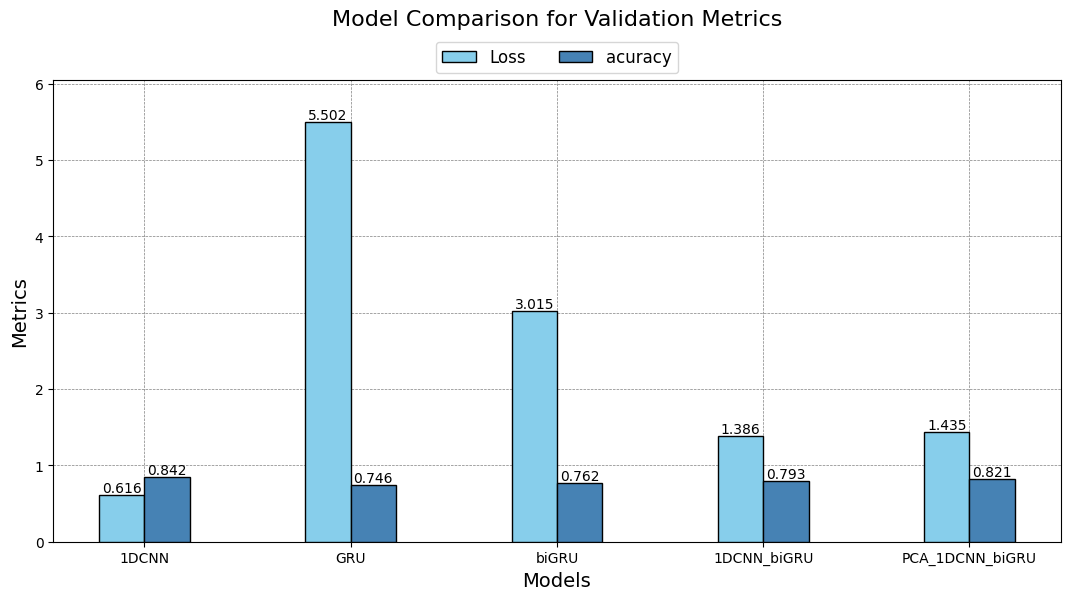

In [18]:
models = ['1DCNN','GRU', 'biGRU', '1DCNN_biGRU', 'PCA_1DCNN_biGRU']
# val_accuracy = [RNN_valid_loss, DCNN_valid_loss, LSTM_valid_loss, GRU_valid_loss, biGRU_valid_loss, DCNN_biGRU_valid_loss]
# val_loss = [RNN_valid_acc, DCNN_valid_acc, LSTM_valid_acc, GRU_valid_acc, biGRU_valid_acc, DCNN_biGRU_valid_acc ]

val_accuracy = [DCNN_valid_loss, GRU_valid_loss, biGRU_valid_loss, DCNN_biGRU_valid_loss, PCA_DCNN_biGRU_valid_loss]
val_loss = [DCNN_valid_acc, GRU_valid_acc, biGRU_valid_acc, DCNN_biGRU_valid_acc, PCA_DCNN_biGRU_valid_acc]

plt.figure(figsize=(12, 6))
# Bar settings
bar_width = 0.22
index = np.arange(len(models))

# Create the plot with a scientific style
# plt.style.use('classic')
fig, ax = plt.subplots(figsize=(13, 6))

# Plot the data with zorder=3 to make sure bars are in front of grid lines
bar1 = ax.bar(index, val_accuracy, bar_width, label='Loss', zorder=3, color='skyblue', edgecolor='black')
bar2 = ax.bar(index + bar_width, val_loss, bar_width, label='acuracy', zorder=3, color='steelblue', edgecolor='black')

# Calculate the max height for a bar to determine text placement
max_height = max(max(val_accuracy), max(val_loss))

# Define a larger offset to move text above the top of the bars
text_offset = max_height * 0.001  # Adjust this factor as needed

# Add text above the bars
for i, rect in enumerate(bar1):
    ax.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), f'{val_accuracy[i]:.3f}', ha='center', va='bottom')

for i, rect in enumerate(bar2):
    ax.text(rect.get_x() + rect.get_width() / 2.0, rect.get_height(), f'{val_loss[i]:.3f}', ha='center', va='bottom')

ax.set_ylim(0, max_height + max_height * 0.1)  # Add 10% headroom above the tallest bar for text

# Annotate the plot
ax.set_title('Model Comparison for Validation Metrics', fontsize=16, loc='center', y=1.1)
ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Metrics', fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Place the legend above the chart
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=12)

# Add grid lines behind the bars by setting zorder=0
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', zorder=0)

# plt.savefig(os.path.join(figure_path, 'bar valid bi.png'))
# print("Plot saved to '{}'.".format(os.path.join(figure_path, 'bar valid bi.png')))

# Show the plot